<h1 style="font-size:400%;
    font-family:Georgia,serif;
	color:#4E443C;
	font-variant: small-caps; text-transform: none; font-weight: 100; margin-bottom: 0;" align="center"> Undervalued Artists </h1>
    
<h1 style="font-family:Georgia,serif;
	color:#4E443C;
	font-variant: small; text-transform: none; font-weight: 100; margin-bottom: 0;" align="center">Identifying the most undervalued artist within 58 000+ artists through time series predictions using multivariate regression</h1>

--------

## **Table of Contents**
* [Background and Purpose](#Background,-Purpose-and-Methodology)
* [Data Import and Overview](#Data-Import-and-Overview)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Data Preprocessing](#Preprocessing)
* [Machine Learning](#Machine-Learning)
* [Predictions](#Predictions)

## Background, Purpose and Methodology

**Purpose:**
- To identify the most undervalued artist within the given dataset.

**Assumptions:** 
- All artists with the provided datasets are unsigned.

**Methodology:**
- Time series prediction through multivariate regression. 

**Project Overview:**
- Dividing the dataset into three windows of 329 days each. Using the features from window T-1 to predict the mean popularity in window T (lagged values).
- Using the 'mean  Spotify popularity score' (the mean popularity is calculated over a period of 329 days for each period) as the target variable.
- Using ensemble learning (voting regressor) by ensembling the two best performing models (Linear Regression and Random Forest Regression) to predict the mean Spotify popularity score for the upcoming period.
- Finally, proposing the artist that have the highest predicted increase in Spotify popularity and a higher estimated popularity score than 75.

## Data Import and Overview


In [1]:
# Data Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading all four datasets
artist_history = pd.read_parquet("../artist_history.parquet",
                                          engine="pyarrow")
artist_releases = pd.read_parquet("../artist_releases.parquet",
                                          engine="pyarrow")
artist_metadata = pd.read_parquet("../artist_metadata.parquet",
                                          engine="pyarrow")
playlist_tracks_history = pd.read_parquet("../playlist_tracks_history.parquet",
                                          engine="pyarrow")

In [853]:
# Putting all datasets and dataset names in lists.
all_datasets = [artist_history, artist_releases, artist_metadata, playlist_tracks_history]
dataset_names = ["artist_history", "artist_releases", "artist_metadata", "playlist_tracks_history"]

In [56]:
# Checking the head values of each dataset for an overview
for i, dataset in enumerate(all_datasets):
    print(dataset_names[i])
    display(dataset.head(3))

artist_history


,spotify_artist_id,mean_value,platform,metric,metric_week
0,4mgrySAI5ikOiFC33XdoXr,7038.0,spotify,followers,2020-08-10
1,6szSMqKKwkFqJoK3MxK3Hk,966858.0,spotify,listeners,2021-02-08
2,5m85RQN2nLv0CXCQs0wKDt,1746.0,spotify,listeners,2020-12-28


artist_releases


,spotify_artist_id,release_date,album_type,main_artist
0,507wnKTa4hle9jlTW0W9eH,2020-03-19,single,True
1,6iLxj9xxV3Y1GhufLa3nfG,2020-05-16,single,True
2,6vyHD8gWqfSC29bgf9RLMc,2019-12-16,single,True


artist_metadata


,spotify_artist_id,artist_name,genres,country
0,4C2lJrO2VHoBJiDac8ygPS,Tais Alvarenga,[baile pop],br
1,1DcaKBFFoVa4dU95oR5l9L,David Shifrin,"[classical performance, classical]",us
2,2IEnjZsVDEPKUTxNinyqba,Tiffany Gouché,"[indie r&b, deep pop r&b, deep indie r&b]",us


playlist_tracks_history


,spotify_track_ids,spotify_artist_ids,position,position_week,playlist_name,editorial,genre
0,[3r6qKw2ldJVpw8QTg2AV93],[7c34Wg8HcWO9BWhHLwiXsr],60.0,2017-10-02,Regueton Viejo,false,"reggaeton, latin, latin hip hop"
1,[066bVDD0IRmC4UF82wbYsU],[5hKv8MEQIS0dj9Dst8hcsc],72.0,2018-06-04,Regueton Viejo,false,"reggaeton, latin, latin hip hop"
2,[721oEB3B3Rr3f3XxhLmpBB],"[5hKv8MEQIS0dj9Dst8hcsc, 3gyTkOT2P0fT3lgJs4dzeW]",10.0,2017-07-10,Regueton Viejo,false,"reggaeton, latin, latin hip hop"


In [38]:
# Checking the shapes of each dataset
for i, dataset in enumerate(all_datasets):
    print(dataset_names[i])
    print(dataset.shape)

artist_history
(36058973, 5)
artist_releases
(2094770, 4)
artist_metadata
(58257, 4)
playlist_tracks_history
(31056897, 7)


artist_history


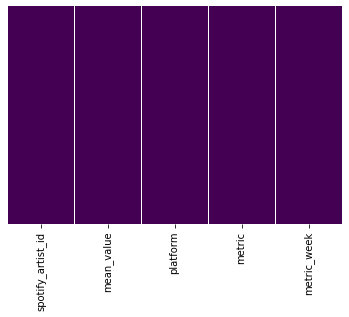

artist_releases


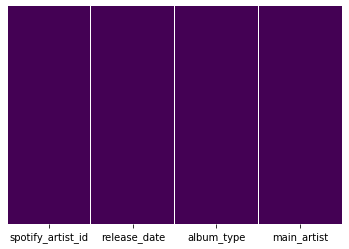

artist_metadata


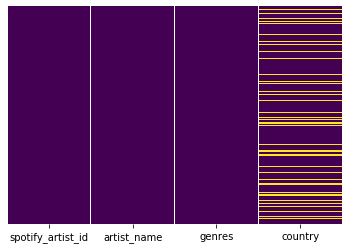

playlist_tracks_history


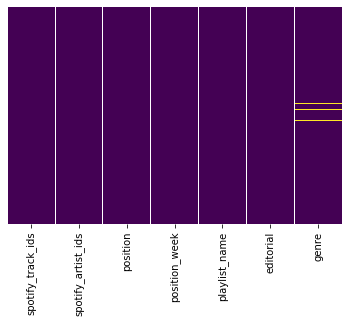

In [39]:
# Checking the null values within the datasets; yellow=null.
for i, dataset in enumerate(all_datasets):
    print(dataset_names[i])
    sns.heatmap(dataset.isnull(), yticklabels=False,
                cbar=False, cmap='viridis')
    plt.show()

As seen in heatmaps above, the features named "country" and "genre" includes null values.

In [17]:
# Checking the datatypes within the dataset
for i, dataset in enumerate(all_datasets):
    print(dataset_names[i])
    display(dataset.info())

artist_history
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36058973 entries, 0 to 36058972
Data columns (total 5 columns):
spotify_artist_id    object
mean_value           float64
platform             object
metric               object
metric_week          object
dtypes: float64(1), object(4)
memory usage: 1.3+ GB


None

artist_releases
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2094770 entries, 0 to 2094769
Data columns (total 4 columns):
spotify_artist_id    object
release_date         object
album_type           object
main_artist          bool
dtypes: bool(1), object(3)
memory usage: 49.9+ MB


None

artist_metadata
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58257 entries, 0 to 58256
Data columns (total 4 columns):
spotify_artist_id    58257 non-null object
artist_name          58257 non-null object
genres               58257 non-null object
country              50543 non-null object
dtypes: object(4)
memory usage: 1.8+ MB


None

playlist_tracks_history
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31056897 entries, 0 to 31056896
Data columns (total 7 columns):
spotify_track_ids     object
spotify_artist_ids    object
position              float64
position_week         object
playlist_name         object
editorial             object
genre                 object
dtypes: float64(1), object(6)
memory usage: 1.6+ GB


None

**The datatypes seem correct except for date values. We will convert the date columns into datetime format within the preprocessing stage.**

## Exploratory Data Analysis

In this section, we take a closer look into the datasets.

### Artist History

In [3]:
artist_history.head(3)

,spotify_artist_id,mean_value,platform,metric,metric_week
0,4mgrySAI5ikOiFC33XdoXr,7038.0,spotify,followers,2020-08-10
1,6szSMqKKwkFqJoK3MxK3Hk,966858.0,spotify,listeners,2021-02-08
2,5m85RQN2nLv0CXCQs0wKDt,1746.0,spotify,listeners,2020-12-28


In [4]:
artist_history.columns

Index(['spotify_artist_id', 'mean_value', 'platform', 'metric', 'metric_week'], dtype='object')

In [5]:
# Converting the metric_week column into datetime datatype.
artist_history["metric_week"] =  artist_history["metric_week"].astype("datetime64[ns]")

/Users/kaya/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


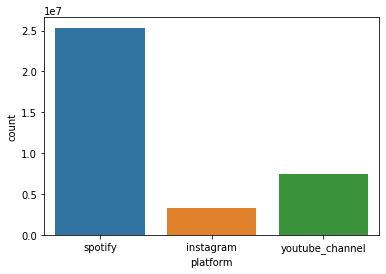

/Users/kaya/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


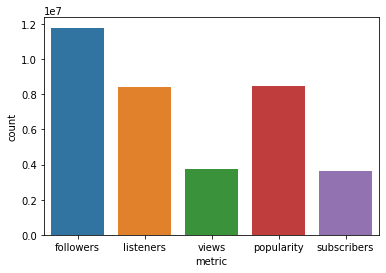

In [30]:
# Checking the distributions of the categorical variables
history_feats = ['platform', 'metric']
for feat in history_feats:
    sns.countplot(artist_history[feat])
    plt.show()

/Users/kaya/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


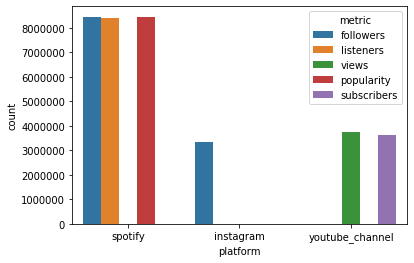

In [854]:
sns.countplot(artist_history["platform"], hue=artist_history["metric"])
plt.show()

ARTIST ID: 4mgrySAI5ikOiFC33XdoXr
Currently: spotify followers


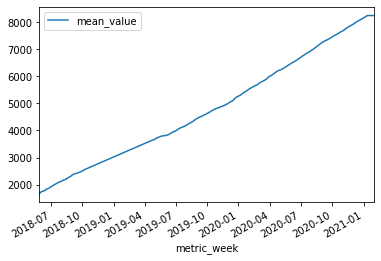

Currently: spotify listeners


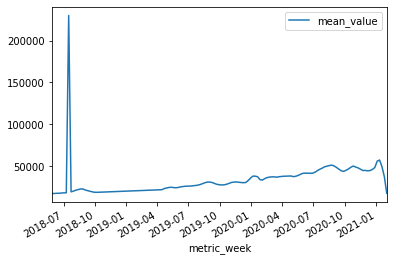

Currently: spotify popularity


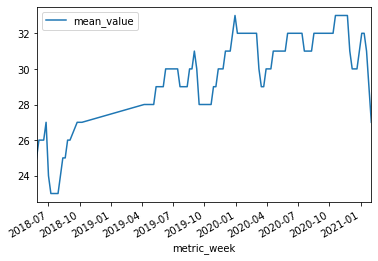

ARTIST ID: 6szSMqKKwkFqJoK3MxK3Hk
Currently: spotify followers


/Users/kaya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


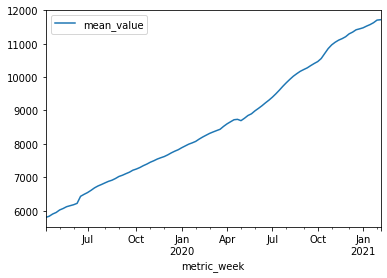

Currently: spotify popularity


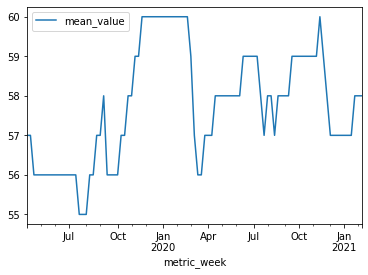

Currently: spotify listeners


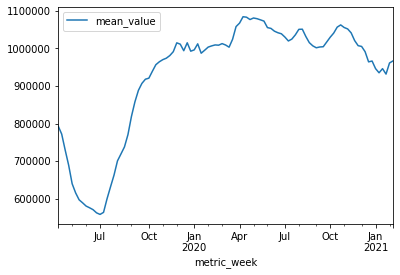

Currently: instagram followers


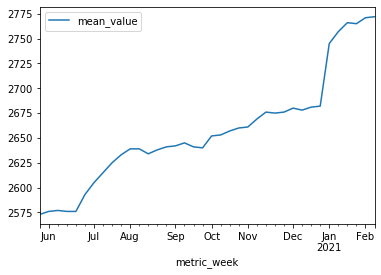

ARTIST ID: 5m85RQN2nLv0CXCQs0wKDt
Currently: spotify followers


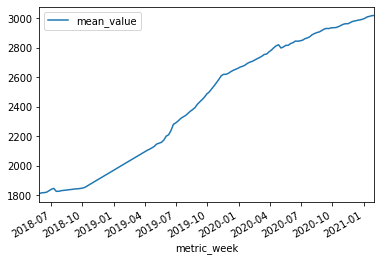

Currently: spotify listeners


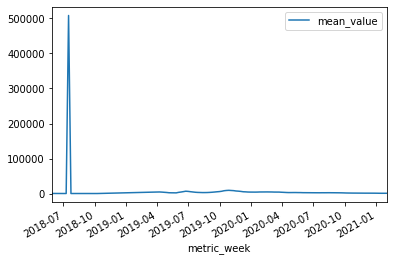

Currently: spotify popularity


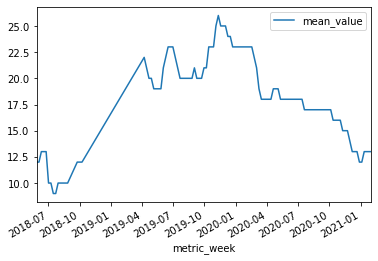

Currently: instagram followers


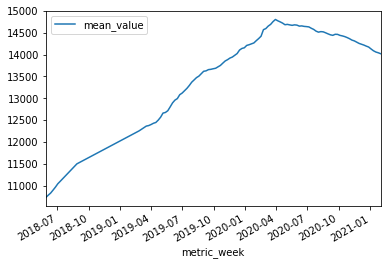

In [884]:
# Taking a look at the development over time of the 3 first artists.
for artist in artist_history["spotify_artist_id"].unique()[:3]:
    print("ARTIST ID:", artist)
    data_vis = artist_history[artist_history["spotify_artist_id"] == artist].copy()
    data_vis.sort_values(by="metric_week", inplace=True)

    for platform in data_vis["platform"].unique():
        for metric in data_vis[data_vis["platform"] == platform]["metric"].unique():
            print("Currently:", platform, metric)
            data_vis[data_vis["platform"] == platform][data_vis["metric"] == metric].plot(x="metric_week", y="mean_value")
            plt.show()

**Insights:**  
- Limiting scope to the Spotify platform due to time constraints
- Assuming popularity is correlated to listeners and followers
- As the popularity varies over time (peaks and valleys), a mean popularity score over a time periods seems reasonable as target value.

### Artist Releases

In [110]:
artist_releases.head(3)

,spotify_artist_id,release_date,album_type,main_artist
0,507wnKTa4hle9jlTW0W9eH,2020-03-19,single,True
1,6iLxj9xxV3Y1GhufLa3nfG,2020-05-16,single,True
2,6vyHD8gWqfSC29bgf9RLMc,2019-12-16,single,True


In [811]:
# Correcting data column into the right datatype
artist_releases["release_date"] =  artist_releases["release_date"].astype("datetime64[ns]")

/Users/kaya/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


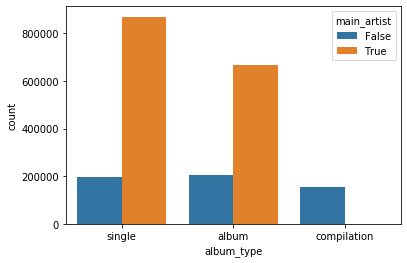

In [111]:
# Checking the distribution of categorical values
sns.countplot(artist_releases["album_type"], hue=artist_releases["main_artist"])

/Users/kaya/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


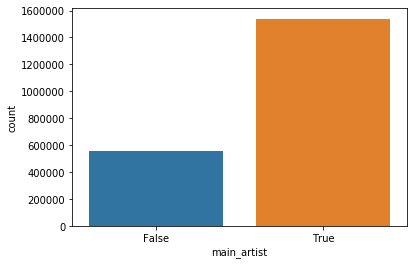

In [112]:
sns.countplot(artist_releases["main_artist"])

**Insights:**  
- Mostly albums and singles, and artists mostly publish songs as main artist.
- I will exclude compilations from this project and limit it to albums and singles.
- Could be very interesting to look at the collaboration numbers and rates for each artist by taking a look at releases where the artist was not the main artist. I will not look at this at the current stage, but could be looked into. 

### Artist Metadata

In [855]:
artist_metadata.head(3)

,spotify_artist_id,artist_name,genres,country
0,4C2lJrO2VHoBJiDac8ygPS,Tais Alvarenga,[baile pop],br
1,1DcaKBFFoVa4dU95oR5l9L,David Shifrin,"[classical performance, classical]",us
2,2IEnjZsVDEPKUTxNinyqba,Tiffany Gouché,"[indie r&b, deep pop r&b, deep indie r&b]",us


In [220]:
# Extracting genres from the dataset in a clean format without brackets
genres_list = []
for l in np.array(artist_metadata.genres):
    ll = l.replace("[", "").replace("]", "").split(",")
    if type(ll) == str:
        genres_list.append(ll.strip())
    else:
        for lll in ll:
            genres_list.append(lll.strip())

In [227]:
from collections import Counter

genres_sorted = Counter(genres_list).most_common()

In [883]:
# Top genres within the dataset
genres_sorted[:5]

[('rock', 1694),
 ('pop', 1257),
 ('hip hop', 1194),
 ('classical', 1109),
 ('jazz', 1004)]

In [230]:
genres_df = pd.DataFrame(genres_sorted, columns=["genre", "count"])

In [396]:
genres_df.iloc[:20]

,genre,count,percentage
0,rock,1694,0.009823
1,pop,1257,0.007289
2,hip hop,1194,0.006924
3,classical,1109,0.006431
4,jazz,1004,0.005822
5,pop rock,751,0.004355
6,latin,730,0.004233
7,dance pop,724,0.004198
8,indie r&b,717,0.004158
9,electro house,708,0.004106


In [232]:
genres_sum = genres_df["count"].sum()
genres_df["percentage"] = genres_df["count"].apply(lambda x: x/genres_sum)

In [856]:
# Setting a genre thresholds at 0.1% and treating all other as outliers.
genre_threshold = 0.005
included_genres = genres_df[genres_df["percentage"] >= genre_threshold]

In [857]:
included_genres_list = list(included_genres["genre"])
len(included_genres_list)

5

Including all genres appearing more than 0.5% of the time and treating all other genres as outliers. This is to filter out very uncommon genres and types of music/sound such as meditation and lounge music.

**Assumption**:  
I assume that the goal is to only sign artists that are within relatively usual genres hence I will exclude the artists that are not within the 0.5% top genres.

**Update: Not including outlier handling in the project due to time constraints; would have to take a closer look into the genres to be able to do a correct outlier handling.**

## Preprocessing

In this section, we perform pre-processing to prepare the data for the Machine Learning models.

### Windows

Here, we divide the dataset into three windows.

In [11]:
# Total number of days within dataset
total_days = (artist_history["metric_week"].max() - artist_history["metric_week"].min())

In [12]:
# Divide into 3 equal windows
total_windows = 3
window_days = total_days/total_windows

In [13]:
window_days

Timedelta('329 days 00:00:00')

In [16]:
# Creating a dict with start and end periods
window_periods = {}
start = artist_history["metric_week"].min()

for i in range(total_windows):
    window_periods[i] = {}
    window_periods[i]["start"] = start + i*window_days
    window_periods[i]["end"] = start + (i+1)*window_days

In [17]:
# Window periods with start and end
window_periods

{0: {'start': Timestamp('2018-05-28 00:00:00'),
  'end': Timestamp('2019-04-22 00:00:00')},
 1: {'start': Timestamp('2019-04-22 00:00:00'),
  'end': Timestamp('2020-03-16 00:00:00')},
 2: {'start': Timestamp('2020-03-16 00:00:00'),
  'end': Timestamp('2021-02-08 00:00:00')}}

In [859]:
# Helper function that divides the provided dataset into 3 periods based on a provided date column.
def divide_dataset(df, date_col, total_windows=3):
    df_popularities = []
    for i in range(total_windows):
        df_window = df[df[date_col] > window_periods[i]["start"]][df[date_col] <= window_periods[i]["end"]]
        if i == 0:
            df_window.append(df[df[date_col] == df[date_col].min()])
        df_popularities.append(df_window)
    return df_popularities

**How the regression model will be trained**

X: PERIOD 1 | PERIOD 2 | PERIOD 3


      
y: PERIOD 2 | PERIOD 3 | **PREDICTION**



- The model uses the artist's activity for the last period (329 days) to predict the artist's average popularity within the upcoming period.

### Extracting The Target Value (Mean Period Popularity)

In [18]:
# Function that returns the mean popularity for each artist for the given dataframe
def mean_popularity(df):
    return df[df["platform"] == "spotify"][df["metric"] == "popularity"].groupby("spotify_artist_id").mean()   

In [122]:
# Calculating the mean popularities for each artist within each period
df_divided = divide_dataset(artist_history, date_col="metric_week")
df_popularities = []
for df in df_divided:
    df_popularities.append(mean_popularity(df))

/Users/kaya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/kaya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [123]:
# Rename columns to respective period three periods: (0, 1, 2)
for i, df in enumerate(df_popularities):
    df.rename(columns={'mean_value': 'mean_value_{}'.format(i)}, inplace=True)

In [124]:
# Doing an inner join on the three datasets, and only keeping artists that exists within all three periods.
merged_df = pd.merge(df_popularities[0], df_popularities[1], on="spotify_artist_id")
artist_popularities = pd.merge(merged_df, df_popularities[2], on="spotify_artist_id")

Here, we're only keeping artists that exists within all three periods for the sake of consistency.

This means, the model will not be trained on artists that are absent in any of the three periods, e.g. new artists. This is a weakness of the current approach. This could be improved by e.g. decreasing the window sizes (number of days).

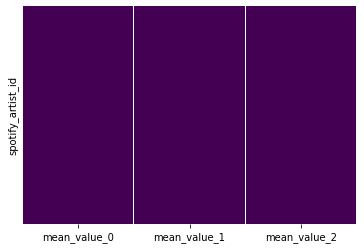

In [125]:
# Doble-checking null values
sns.heatmap(artist_popularities.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [771]:
# Removing multi-index
y = pd.DataFrame(artist_popularities.to_records()).drop("index", axis=1)

In [772]:
# Top 20 most popular artists in the last period
y.head()

,spotify_artist_id,mean_value_0,mean_value_1,mean_value_2
0,0001ZVMPt41Vwzt1zsmuzp,34.085106,13.744681,9.347826
1,000BblCiHJeKvtiq5aiHOs,28.760870,32.319149,33.333333
2,001TRduQniM6dsJbQpMsbJ,40.765957,43.723404,44.021277
3,001aJOc7CSQVo3XzoLG4DK,44.127660,46.936170,47.347826
4,001bpbe3Erwxc1cVfgVuFo,11.875000,24.404255,33.638298


In [499]:
# Backing up the y dataset in a CSV
y.to_csv("y.csv", index=False)

### Extracting the Independent Variables (X) 

In [258]:
# A general helper function to check out artist metadata with the spotify id.
def check_artist(id):
    return artist_metadata[artist_metadata["spotify_artist_id"] == id]

#### 'Artist Releases' variables

Here, we will extract the number of singles and albums each artist has released within each time period as the main artist. 

In [38]:
artist_releases.head()

,spotify_artist_id,release_date,album_type,main_artist
0,507wnKTa4hle9jlTW0W9eH,2020-03-19,single,True
1,6iLxj9xxV3Y1GhufLa3nfG,2020-05-16,single,True
2,6vyHD8gWqfSC29bgf9RLMc,2019-12-16,single,True
3,2abTBfFq5PSoASI2PSysLV,2018-06-05,single,True
4,5yePldMswAMD9fvIfRUc2o,2012-12-10,single,True


In [53]:
window_periods

{0: {'start': Timestamp('2018-05-28 00:00:00'),
  'end': Timestamp('2019-04-22 00:00:00')},
 1: {'start': Timestamp('2019-04-22 00:00:00'),
  'end': Timestamp('2020-03-16 00:00:00')},
 2: {'start': Timestamp('2020-03-16 00:00:00'),
  'end': Timestamp('2021-02-08 00:00:00')}}

In [398]:
artist_releases.shape

(2094770, 4)

In [537]:
# Divide dataset into the window periods displayed above
df_divided = divide_dataset(artist_releases, date_col="release_date")

/Users/kaya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [399]:
# Shapes of the datasets corresponding to each period
for df in df_divided:
    display(df.shape)

(229934, 4)

(321776, 4)

(405988, 4)

In [400]:
# Printing the single, album and compilation count per artist for the first period (window 0).
for at in artist_releases["album_type"].unique():
    print(at)
    df = df_divided[0][df_divided[0]["album_type"] == at]
    df = pd.DataFrame(df[df["main_artist"]==True].groupby("spotify_artist_id")["album_type"].agg(['count']).to_records())
    display(df.sort_values("count", ascending=False).iloc[:20])

single


,spotify_artist_id,count
3822,0lFDQOEK5OwsyPXb1aWJzY,443
22004,4TkCMPznXOjlsYLfzIU1rw,375
37846,7qyRt0liryfC7zuZFICdKC,264
11515,2Lfacnt7JaOueXRyim7q08,249
26675,5QYPnAeEqVZSEi7VbY9Fum,237
23292,4jxICVokHTn2J2VwTCvPxm,222
12315,2Voym2yJawg9ChaAiybFJv,206
353,04T7QEqAiQBW12loi1g2CO,188
5265,147CSVEqbtAs61RiDlLW7N,176
15958,3GghVvugpv9nXQ2YFzZNzN,158


album


,spotify_artist_id,count
6442,3paPKXFFD404Fuonc8DvnN,463
12535,7dJ05O9EOtFVROVfEEHBBc,452
2382,1NxJIytLijquteDSmuDM8I,384
3955,2MYk6exrOI4fr9OfG3qPIQ,370
1002,0a7IMVQLynzliWvqoPo5tE,369
8663,58yicdDBopSJkQdBVZqCbs,350
10556,6IJx7h0cuM3736FwR8Myiv,347
10418,6DRwKWnvWIApUcEUqbyM5Z,344
226,08u9L6t2nbl4zHMkQ642d2,339
9615,5lKaPKuNyNz6LN6NfM5vz1,333


compilation


,spotify_artist_id,count


In [261]:
# Checking artists with very high single, album and compilation counts (per year)
display(check_artist("1wxPItEzr7U7rGSMPqZ25r"))
display(check_artist("5xgmHcltQrXqemjFhRy693"))
display(check_artist("2a1ku6axhh00M3y40JK2as"))

,spotify_artist_id,artist_name,genres,country
56926,1wxPItEzr7U7rGSMPqZ25r,Shiloh Dynasty,[lo-fi beats],None


,spotify_artist_id,artist_name,genres,country
51642,5xgmHcltQrXqemjFhRy693,Eskimotion,"[kirtan, new tribe, healing, meditation]",None


,spotify_artist_id,artist_name,genres,country
44047,2a1ku6axhh00M3y40JK2as,Raphaël Novarina,"[musica de fondo, pianissimo]",fr


Above is an example of outliers within the dataset regarding genre, e.g. Eskimotion have released 464 "albums" in a shorter period than a year. This is clearly not an usual datapoint.

With the assumption that the goal is to sign an artist within a relatively common genre and with the risk of biasing the model training with these unusually high single / album counts, we will exclude all artists that have over 10 albums released during a time window of 329 days. This is a workaround and a better outlier detecton can be applied.

In [405]:
# For the sake of time, we will only look at albums released by the artist as the main artist.
for i, df in enumerate(df_divided):
    df_divided[i] = df[df["main_artist"] == True]

In [504]:
# We create three X datasets, one for each period, by using the groupby and count functions
X = []
for i, df in enumerate(df_divided):
    X_list = []
    for at in ["album", "single"]:
        df_x = df_divided[i][df_divided[i]["album_type"] == at]
        df_x = pd.DataFrame(df_x.groupby("spotify_artist_id")["album_type"].agg(['count']).to_records())
        df_x.rename(columns={'count': at}, inplace=True)
        X_list.append(df_x)
    
    # Doing an inner join on the three datasets.
    merged_df = pd.merge(X_list[0], X_list[1], on="spotify_artist_id")
    X.append(merged_df)

In [505]:
# Only pick artists with less than 10 albums during the window-period
album_limit = 10
for i, df in enumerate(X):
    X[i] = df[df["album"]<album_limit]

In [506]:
# Checking the first dataset
X[0]

,spotify_artist_id,album,single
0,001aJOc7CSQVo3XzoLG4DK,1,2
1,001bpbe3Erwxc1cVfgVuFo,1,2
2,003f4bk13c6Q3gAUXv7dGJ,1,1
3,0052sLPmKyG6ou86BEhYjt,1,2
4,006ibfxHXj6ewIkihKcaS2,3,4
...,...,...,...
13164,7zrWMnPOpwr5AEt670VKMc,3,6
13165,7zsebMNso4mnBsQ28HWFcC,3,8
13166,7zuoqJAXDtNaLzxxm4IShD,1,3
13167,7zyObVag8rUjItn71SkIrh,1,5


In [507]:
# Backing up the so-far preprocessed data in a CSV
for i, df in enumerate(X):
    file_name = "X_history_{}.csv".format(i)
    df.to_csv(file_name, index=False)

Now we have the number of albums and singles for each artist during each period.

#### playlist_tracks_history

In this section, we will extract the number of times each artist has been present in a 1) private playlist and 2) editorial playlist. We will not consider collaborations.

In [524]:
playlist_tracks_history.head()

,spotify_track_ids,spotify_artist_ids,position,position_week,playlist_name,editorial,genre
0,[3r6qKw2ldJVpw8QTg2AV93],[7c34Wg8HcWO9BWhHLwiXsr],60.0,2017-10-02,Regueton Viejo,false,"reggaeton, latin, latin hip hop"
1,[066bVDD0IRmC4UF82wbYsU],[5hKv8MEQIS0dj9Dst8hcsc],72.0,2018-06-04,Regueton Viejo,false,"reggaeton, latin, latin hip hop"
2,[721oEB3B3Rr3f3XxhLmpBB],"[5hKv8MEQIS0dj9Dst8hcsc, 3gyTkOT2P0fT3lgJs4dzeW]",10.0,2017-07-10,Regueton Viejo,false,"reggaeton, latin, latin hip hop"
3,[3vqLEWtFLuOTx753CizxAS],"[5hKv8MEQIS0dj9Dst8hcsc, 1hCNLXLaacQf1b93gCGbbn]",70.0,2017-07-10,Regueton Viejo,false,"reggaeton, latin, latin hip hop"
4,[6aga6bzDP9vR0kQiMYSP7x],"[5hKv8MEQIS0dj9Dst8hcsc, 3WQRkINylwwkw1Ya07ToRK]",85.0,2017-10-30,Regueton Viejo,false,"reggaeton, latin, latin hip hop"


In [621]:
# Divide dataset into the window periods
df_divided = divide_dataset(playlist_tracks_history, date_col="position_week")

/Users/kaya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [622]:
# Cleaning the spotify_artist_ids column by removing the brackets and storing like strings.
for df in df_divided:
    df["spotify_artist_id"] = df["spotify_artist_ids"].apply(lambda x: str(x).replace("[", "").replace("]", ""))
    df.drop(["spotify_artist_ids"], axis=1, inplace=True)

In [623]:
# Creating one dataset for each period by using the groupby and count functions.
X_playlists = []
for i, df in enumerate(df_divided):
    df_x = df_divided[i].groupby(["spotify_artist_id", "editorial"]).size().reset_index(
        name='counts')
    df_final = df_x[df_x["editorial"] == "false"][["spotify_artist_id", "counts"]].rename(
        columns={'counts': "not_editorial_playlist"})
    df_final = df_final.merge(df_x[df_x["editorial"] == "true"][[
                              "spotify_artist_id", "counts"]], how="outer", on="spotify_artist_id").rename(columns={'counts': "editorial_playlist"})
    X_playlists.append(df_final)

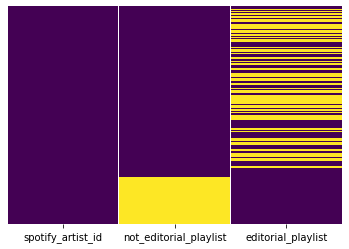

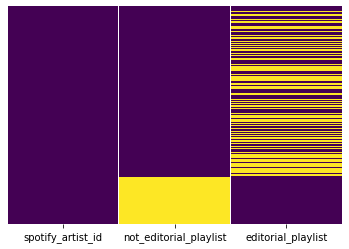

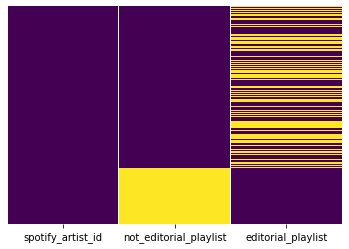

In [628]:
# We check the null values
for df in X_playlists:
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.show()

As seen above, when an artist did not have a record in a playlist it was filled with null. We will replace all the null values with 0s.

In [629]:
# Filling all null values with 0s.
for i, df in enumerate(X_playlists):
    X_playlists[i] = df.fillna(0)

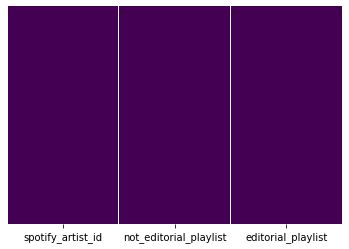

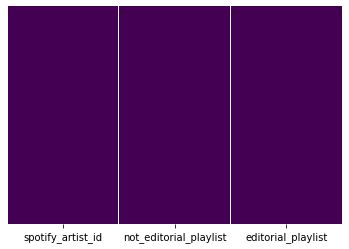

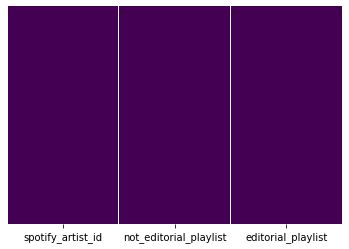

In [630]:
for df in X_playlists:
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.show()

In [576]:
# Double checking the playlist counts for one random artist within the first dataset
df_divided[0][df_divided[0]["spotify_artist_ids"] == "004F88I7EWH54o9jNfUbEn"]

,spotify_track_ids,spotify_artist_ids,position,position_week,playlist_name,editorial,genre
23030919,[31xeZAhffVTxivFZB1k5jz],004F88I7EWH54o9jNfUbEn,222.0,2019-03-04,My Favorite Covers,false,"coverchill, jazz"
23031362,[5nxpI5lTyWIURE5sj9M0lt],004F88I7EWH54o9jNfUbEn,157.0,2019-01-07,My Favorite Covers,false,"coverchill, jazz"
23031403,[31xeZAhffVTxivFZB1k5jz],004F88I7EWH54o9jNfUbEn,227.0,2019-03-18,My Favorite Covers,false,"coverchill, jazz"
23031408,[5nxpI5lTyWIURE5sj9M0lt],004F88I7EWH54o9jNfUbEn,131.0,2018-06-04,My Favorite Covers,false,"coverchill, jazz"
23031409,[04v7FXb6Z6hzmWhqRYfwLP],004F88I7EWH54o9jNfUbEn,159.0,2018-11-12,My Favorite Covers,false,"coverchill, jazz"
...,...,...,...,...,...,...,...
24725835,[04v7FXb6Z6hzmWhqRYfwLP],004F88I7EWH54o9jNfUbEn,242.0,2018-12-31,Vintage Café - Official Playlist,false,"coverchill, jazz"
24725844,[04v7FXb6Z6hzmWhqRYfwLP],004F88I7EWH54o9jNfUbEn,238.0,2019-01-28,Vintage Café - Official Playlist,false,"coverchill, jazz"
24725989,[31xeZAhffVTxivFZB1k5jz],004F88I7EWH54o9jNfUbEn,262.0,2019-02-04,Vintage Café - Official Playlist,false,"coverchill, jazz"
24726027,[04v7FXb6Z6hzmWhqRYfwLP],004F88I7EWH54o9jNfUbEn,262.0,2018-07-23,Vintage Café - Official Playlist,false,"coverchill, jazz"


### Combining the Extracted features

In [631]:
# Merging the datasets with left outer joins.
X_final = []
for i in range(len(X)):
    X_final.append(X[i].merge(X_playlists[i], on="spotify_artist_id"))

In [635]:
# Overview of dataset so far.
X_final[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9452 entries, 0 to 9451
Data columns (total 5 columns):
spotify_artist_id         9452 non-null object
album                     9452 non-null int64
single                    9452 non-null int64
not_editorial_playlist    9452 non-null float64
editorial_playlist        9452 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 443.1+ KB


In [645]:
X_final[0]

,spotify_artist_id,album,single,not_editorial_playlist,editorial_playlist
0,001aJOc7CSQVo3XzoLG4DK,1,2,3.0,1.0
1,0052sLPmKyG6ou86BEhYjt,1,2,0.0,35.0
2,006ibfxHXj6ewIkihKcaS2,3,4,8.0,3.0
3,008PpLcKUtVXle6JSwkq3I,1,3,0.0,10.0
4,009IKtLg2rg2QMbvNtWaoh,3,6,0.0,4.0
...,...,...,...,...,...
9447,7zmuMr74dNGqjq74uibncO,2,3,17.0,9.0
9448,7zmxRagidm9E5dF0mGhQ6K,5,8,0.0,2.0
9449,7zrWMnPOpwr5AEt670VKMc,3,6,2.0,5.0
9450,7zyObVag8rUjItn71SkIrh,1,5,36.0,217.0


### Normalizing X and y

#### Normalizing y

Normalizing y since it is going to be used as a dependent variable in X aswell. 

In [653]:
from sklearn.preprocessing import MinMaxScaler

In [654]:
mms = MinMaxScaler()

In [663]:
y

,index,spotify_artist_id,mean_value_0,mean_value_1,mean_value_2
0,0,0001ZVMPt41Vwzt1zsmuzp,34.085106,13.744681,9.347826
1,1,000BblCiHJeKvtiq5aiHOs,28.760870,32.319149,33.333333
2,2,001TRduQniM6dsJbQpMsbJ,40.765957,43.723404,44.021277
3,3,001aJOc7CSQVo3XzoLG4DK,44.127660,46.936170,47.347826
4,4,001bpbe3Erwxc1cVfgVuFo,11.875000,24.404255,33.638298
...,...,...,...,...,...
64103,64103,7zxbGCI5DeZCwpbYXn20it,13.500000,12.869565,12.217391
64104,64104,7zyObVag8rUjItn71SkIrh,40.269231,50.800000,57.893617
64105,64105,7zySlNgrPI1dWfMBIjTIKD,39.550000,39.361702,38.652174
64106,64106,7zyWAQgUX6rJprlFm6sqFv,20.666667,26.488889,41.068966


In [664]:
# Dropping the index column
y.drop("index", axis=1, inplace=True)

In [668]:
# Normalizing y through MinMax
y_normalized = y.copy()
num_feats_y = [feature for feature in y_normalized.columns if y_normalized[feature].dtype != "O"]

y_normalized[num_feats_y] = mms.fit_transform(y_normalized[num_feats_y])
y_normalized

,spotify_artist_id,mean_value_0,mean_value_1,mean_value_2
0,0001ZVMPt41Vwzt1zsmuzp,0.397223,0.154088,0.104141
1,000BblCiHJeKvtiq5aiHOs,0.335175,0.362322,0.371357
2,001TRduQniM6dsJbQpMsbJ,0.475081,0.490173,0.490428
3,001aJOc7CSQVo3XzoLG4DK,0.514257,0.526190,0.527488
4,001bpbe3Erwxc1cVfgVuFo,0.138390,0.273590,0.374755
...,...,...,...,...
64103,7zxbGCI5DeZCwpbYXn20it,0.157327,0.144278,0.136110
64104,7zyObVag8rUjItn71SkIrh,0.469292,0.569507,0.644976
64105,7zySlNgrPI1dWfMBIjTIKD,0.460910,0.441275,0.430613
64106,7zyWAQgUX6rJprlFm6sqFv,0.240846,0.296961,0.457538


#### Normalizing X

In [655]:
num_feats

['album', 'single', 'not_editorial_playlist', 'editorial_playlist']

In [657]:
# Normalizing all features in X except for the artist ID.
X_normalized = []
for df in X_final:
    df_x = df.copy()
    df_x[num_feats] = mms.fit_transform(df[num_feats])
    X_normalized.append(df_x)

In [659]:
X_normalized[0]

,spotify_artist_id,album,single,not_editorial_playlist,editorial_playlist
0,001aJOc7CSQVo3XzoLG4DK,0.000,0.010638,0.000570,0.000425
1,0052sLPmKyG6ou86BEhYjt,0.000,0.010638,0.000000,0.014862
2,006ibfxHXj6ewIkihKcaS2,0.250,0.031915,0.001520,0.001274
3,008PpLcKUtVXle6JSwkq3I,0.000,0.021277,0.000000,0.004246
4,009IKtLg2rg2QMbvNtWaoh,0.250,0.053191,0.000000,0.001699
...,...,...,...,...,...
9447,7zmuMr74dNGqjq74uibncO,0.125,0.021277,0.003231,0.003822
9448,7zmxRagidm9E5dF0mGhQ6K,0.500,0.074468,0.000000,0.000849
9449,7zrWMnPOpwr5AEt670VKMc,0.250,0.053191,0.000380,0.002123
9450,7zyObVag8rUjItn71SkIrh,0.000,0.042553,0.006842,0.092144


In [682]:
'''
Since the model will use the values from the current period to predict the mean popularity 
score for the upcoming period, we will use the current period's mean popularity as a feature.
Below, we attach the current period's mean popularity to the X dataset
'''
preprocessed_df = []
for i, df in enumerate(X_normalized):
    y_col_name = "mean_value_{}".format(i)
    y_col_next = "mean_value_{}".format(i+1)
    df_new = df.merge(y_normalized[["spotify_artist_id", y_col_name]], on="spotify_artist_id").rename(
        columns={y_col_name: "mean_popularity"})
    try:
        df_new = df_new.merge(y_normalized[["spotify_artist_id", y_col_next]], on="spotify_artist_id").rename(
            columns={y_col_next: "y"})
    except:
        pass
    
    preprocessed_df.append(df_new)

In [690]:
''' 
As seen below, the two first datasets will be used to train the model 
and the last X set will be for the model to predict.
'''
for df in preprocessed_df:
    display(df.head(2))

,spotify_artist_id,album,single,not_editorial_playlist,editorial_playlist,mean_popularity,y
0,001aJOc7CSQVo3XzoLG4DK,0.0,0.010638,0.00057,0.000425,0.514257,0.526190
1,0052sLPmKyG6ou86BEhYjt,0.0,0.010638,0.00000,0.014862,0.512026,0.523279


,spotify_artist_id,album,single,not_editorial_playlist,editorial_playlist,mean_popularity,y
0,001aJOc7CSQVo3XzoLG4DK,0.125,0.007143,0.002023,0.001584,0.526190,0.527488
1,001o475CIcdKHkvgKc9t8H,0.000,0.042857,0.000368,0.001056,0.499237,0.533806


,spotify_artist_id,album,single,not_editorial_playlist,editorial_playlist,mean_popularity
0,001aJOc7CSQVo3XzoLG4DK,0.0,0.004630,0.001626,0.004618,0.527488
1,001o475CIcdKHkvgKc9t8H,0.0,0.009259,0.000155,0.003519,0.533806


In [691]:
# Finalizing the preprocessing stage by preparing the datasets to be used for the machine learning.
dff = preprocessed_df[0].append(preprocessed_df[1])

X = dff.drop(["spotify_artist_id", "y"], axis=1)
y = dff["y"]
X_pred = preprocessed_df[2]

In [696]:
X.head()

,album,single,not_editorial_playlist,editorial_playlist,mean_popularity
0,0.00,0.010638,0.00057,0.000425,0.514257
1,0.00,0.010638,0.00000,0.014862,0.512026
2,0.25,0.031915,0.00152,0.001274,0.404338
3,0.00,0.021277,0.00000,0.004246,0.321646
4,0.25,0.053191,0.00000,0.001699,0.463923


In [697]:
y.head()

0    0.526190
1    0.523279
2    0.463696
3    0.588207
4    0.472999
Name: y, dtype: float64

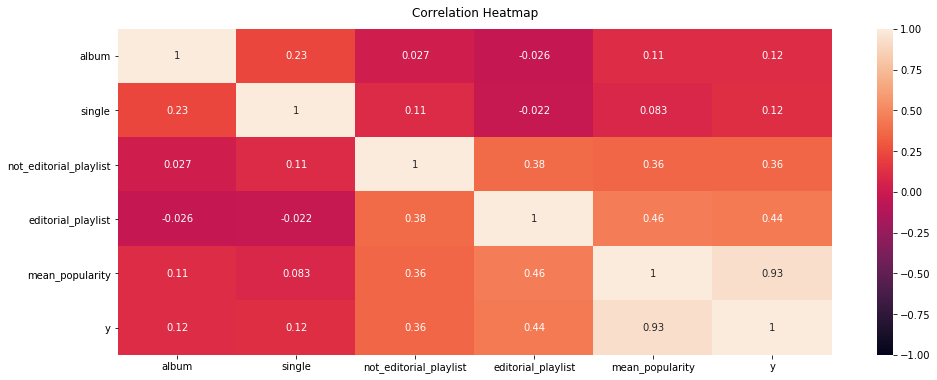

In [860]:
# Checking the correlation between the variables and the y variable.
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dff.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### Splitting the dataset into train and test

In [698]:
from sklearn.model_selection import train_test_split

In [699]:
# Randomized split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [700]:
X_train.shape

(15415, 5)

In [701]:
X_test.shape

(3854, 5)

More features that could be included:
- Single to album ratio
- Collaborations
- IG metrics 
- Youtube metrics
- Genres (one-hot encoded)
- Countries (one-hot encoded)

Other Approaches to look into:
- For the time series regression: could take weekly data instead
- Rolling window yield a better result

## Machine Learning

### Training Models

In [704]:
# Some Regression models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Cross-validation
from sklearn.model_selection import cross_val_score

In [719]:
# Display model scores (errors and std. dev.)
def display_scores(scores):
    print("Mean Errors: ", scores)
    print("Overall Mean Error: ", scores.mean())
    print("Std: ", scores.std())

In [720]:
# Linear Regression
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, X_train, y_train,
                       scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Mean Errors:  [0.04870074 0.0464383  0.04582772 0.04417095 0.04950278 0.04882868
 0.04613783 0.04509551 0.04740421 0.04841551]
Overall Mean Error:  0.04705222459334228
Std:  0.0016942240043244696


In [721]:
# Decision Tree Regression
dt_reg = DecisionTreeRegressor()
scores = cross_val_score(dt_reg, X_train, y_train,
                       scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Mean Errors:  [0.06973628 0.06396341 0.06153841 0.06296606 0.0664362  0.06835934
 0.06743016 0.0632381  0.06749492 0.06976659]
Overall Mean Error:  0.06609294759421588
Std:  0.0028104073071417617


In [734]:
# Random Forest Regression
rnd_reg = RandomForestRegressor()
scores = cross_val_score(rnd_reg, X_train, y_train,
                       scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Mean Errors:  [0.04845085 0.04782457 0.04578412 0.04452342 0.0485736  0.04822155
 0.04638297 0.04566445 0.04885574 0.04756643]
Overall Mean Error:  0.047184769806885817
Std:  0.0014125415767783577


In [723]:
# K Neighbors Regression
kn_reg = KNeighborsRegressor()
scores = cross_val_score(kn_reg, X_train, y_train,
                       scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Mean Errors:  [0.05190937 0.04993321 0.04761155 0.0463791  0.04950497 0.05004948
 0.04921428 0.04842397 0.05114247 0.05092825]
Overall Mean Error:  0.0495096662187469
Std:  0.0015992835309683643


In [724]:
# K Neighbors Regression
svm_reg = SVR()
scores = cross_val_score(svm_reg, X_train, y_train,
                       scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Mean Errors:  [0.05075256 0.04984442 0.04773321 0.04696867 0.04997379 0.05019732
 0.04876292 0.04804008 0.0503904  0.04973491]
Overall Mean Error:  0.04923982820896124
Std:  0.0012154482881187568


### Hyperparameter tuning

Based on the results from above, we select two models for hyperparameter tuning: the linear regression and the random forest regression.

In [738]:
from sklearn.model_selection import GridSearchCV

In [737]:
# Taking a look at current parameters
rnd_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [739]:
# Using grid search to tune the hyperparameters of the rnd forest regressor. 
param_grid = [
    {'n_estimators': [50, 100, 150, 300, 600], 'max_features': ['auto', 'sqrt', 'log2']},
    {'bootstrap': [False], 'n_estimators': [50, 100, 150, 300, 600], 'max_features': ['auto', 'sqrt', 'log2']},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error",
                          return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [50, 100, 150, 300, 600]},
                         {'bootstrap': [False],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'n_estimators': [50, 100, 150, 300, 600]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [740]:
print("Best Score:", np.sqrt(-grid_search.best_score_))

Best Score: 0.04616211806832253


### Ensemble learning

We further try to improve the model by ensembling the above tuned model and the next best model (lin_reg).

In [741]:
from sklearn.ensemble import VotingRegressor

In [748]:
rnd_clf = grid_search.best_estimator_
lin_reg = LinearRegression()

voting_reg = VotingRegressor(
            estimators=[('rnd', rnd_clf), ('lin_reg', lin_reg)],
            n_jobs=-1, verbose=True)

scores = cross_val_score(voting_reg, X_train, y_train,
                       scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Mean Errors:  [0.04737425 0.04566762 0.04437742 0.04260569 0.047449   0.046627
 0.04470966 0.04404119 0.04662975 0.04631285]
Overall Mean Error:  0.04557944458475087
Std:  0.0015124007867193098


In [749]:
# Training the voting regressor
voting_reg = VotingRegressor(
            estimators=[('rnd', rnd_clf), ('lin_reg', lin_reg)],
            n_jobs=-1, verbose=True)

voting_reg.fit(X_train, y_train)

VotingRegressor(estimators=[('rnd',
                             RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=600)),
                            ('lin_reg', LinearRegression())],
                n_jobs=-1, verbose=True)

### Evaluation on the Test Set

In [752]:
from sklearn.metrics import mean_squared_error

In [753]:
# Measuring the MSE on the test set
y_test_pred = voting_reg.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
rmse

0.04394710124869699

Not bad, the model performed even better on the test set than the validation set.

## Predictions

In this section, we predict the mean popularity for the artists for the upcoming period.

In [755]:
X_pred.head()

,spotify_artist_id,album,single,not_editorial_playlist,editorial_playlist,mean_popularity
0,001aJOc7CSQVo3XzoLG4DK,0.000,0.004630,0.001626,0.004618,0.527488
1,001o475CIcdKHkvgKc9t8H,0.000,0.009259,0.000155,0.003519,0.533806
2,003Lrmd4Hy04kSf0wZm3xm,0.125,0.000000,0.000000,0.016055,0.383475
3,003aZdOERqXUCxNAS91ZZt,0.000,0.018519,0.000000,0.002199,0.333776
4,0052sLPmKyG6ou86BEhYjt,0.000,0.004630,0.000077,0.021113,0.501090


In [756]:
# Predicting using the voting regressor
y_pred = voting_reg.predict(X_pred.drop("spotify_artist_id", axis=1))

In [763]:
# The predictions
y_pred

array([0.5236581 , 0.54336961, 0.43199061, ..., 0.40984749, 0.50834728,
       0.49256533])

In [764]:
# Adding the artist ids to the predictions
artist_predictions = X_pred.copy()
artist_predictions["predicted_popularity"] = y_pred
artist_predictions = artist_predictions[["spotify_artist_id", "predicted_popularity"]]

In [765]:
artist_predictions.head()

,spotify_artist_id,predicted_popularity
0,001aJOc7CSQVo3XzoLG4DK,0.523658
1,001o475CIcdKHkvgKc9t8H,0.543370
2,003Lrmd4Hy04kSf0wZm3xm,0.431991
3,003aZdOERqXUCxNAS91ZZt,0.395796
4,0052sLPmKyG6ou86BEhYjt,0.508495


In [777]:
# Combining the artist popularities during the first three periods with the predicted popularity.
all_popularities = y_normalized.copy().merge(artist_predictions, on="spotify_artist_id")

In [778]:
all_popularities.shape

(10606, 5)

In [779]:
# All mean popularties including the predicted one
all_popularities.head()

,spotify_artist_id,mean_value_0,mean_value_1,mean_value_2,predicted_popularity
0,001aJOc7CSQVo3XzoLG4DK,0.514257,0.526190,0.527488,0.523658
1,001o475CIcdKHkvgKc9t8H,0.400116,0.499237,0.533806,0.543370
2,003Lrmd4Hy04kSf0wZm3xm,0.452220,0.408358,0.383475,0.431991
3,003aZdOERqXUCxNAS91ZZt,0.462270,0.366377,0.333776,0.395796
4,0052sLPmKyG6ou86BEhYjt,0.512026,0.523279,0.501090,0.508495


In [782]:
# Calculating the increase in mean popularity from the current period to the predicted (next) period
new = all_popularities["predicted_popularity"]
old = all_popularities["mean_value_2"]
all_popularities["predicted_increase_%"] = ((new-old)/old)*100

In [863]:
'''
Setting a popularity threshold at 0.75 (excluding artists with under 0.75 popularity score) and then sorting on the artists with highest predicted increases
'''
popularity_threshold = 0.75
all_popularities[all_popularities["predicted_popularity"]>popularity_threshold].sort_values("predicted_increase_%", ascending=False)

,spotify_artist_id,mean_value_0,mean_value_1,mean_value_2,predicted_popularity,predicted_increase_%
938,0f1IECbrVV952unZkzrsg2,0.713117,0.694320,0.713490,0.752582,5.479044
10577,7ygNQCdpQWW7iSWAxDhvhI,0.618921,0.829181,0.730443,0.757014,3.637626
5310,3t2iKODSDyzoDJw7AsD99u,0.887181,0.882726,0.894163,0.909906,1.760597
9233,6oMRQ5H3A2XA5I3RG3leni,0.649286,0.660242,0.747850,0.760167,1.647012
2485,1mvpEXClANunyiHFtAXCxt,0.577119,0.749213,0.746912,0.756484,1.281584
...,...,...,...,...,...,...
7679,5gCRApTajqwbnHHPbr2Fpi,0.927597,0.896384,0.866554,0.816969,-5.722035
3068,2DspEsT7UXGKd2VaaedgG4,0.876023,0.880880,0.876483,0.825911,-5.769925
7531,5YwzDz4RJfTiMHS4tdR5Lf,0.833251,0.849527,0.855171,0.800537,-6.388598
6232,4YRxDV8wJFPHPTeXepOstw,0.730970,0.880641,0.922072,0.850210,-7.793474


**The one artist to sign that is already popular, based on the model is:**

In [881]:
# The artist top 2 artists that are predicted to grow most and have a popularity score over 0.75 for the upcoming period.
display(check_artist("0f1IECbrVV952unZkzrsg2"))

,spotify_artist_id,artist_name,genres,country
41025,0f1IECbrVV952unZkzrsg2,Mc Gw,[deep funk carioca],br


In [862]:
all_popularities.sort_values("predicted_increase_%", ascending=False)

,spotify_artist_id,mean_value_0,mean_value_1,mean_value_2,predicted_popularity,predicted_increase_%
9006,6eaNKQQiIUDWn1BnzF4EI6,0.176132,0.088493,0.039246,0.182464,364.927680
2408,1jMfJHQ15Re788JJsThwOo,0.400116,0.058439,0.081376,0.203135,149.626799
10351,7pLUtCU60PW0ZqDUC2ZULh,0.147357,0.135483,0.114726,0.245062,113.606608
10106,7dn0zONpPGBUdPmzRYS7x9,0.029135,0.033377,0.117596,0.241735,105.563237
1023,0imTTiC5dn6qy1VNS9Ituf,0.231912,0.172918,0.150400,0.288896,92.085658
...,...,...,...,...,...,...
7679,5gCRApTajqwbnHHPbr2Fpi,0.927597,0.896384,0.866554,0.816969,-5.722035
3068,2DspEsT7UXGKd2VaaedgG4,0.876023,0.880880,0.876483,0.825911,-5.769925
7531,5YwzDz4RJfTiMHS4tdR5Lf,0.833251,0.849527,0.855171,0.800537,-6.388598
6232,4YRxDV8wJFPHPTeXepOstw,0.730970,0.880641,0.922072,0.850210,-7.793474


**Two artists worth looking into and that are not already popular are:**

In [879]:
# The top 3rd and 5th artist with the highest predicted increase in mean popularity, regardless of popularity score.
display(check_artist("7pLUtCU60PW0ZqDUC2ZULh"))
display(check_artist("0imTTiC5dn6qy1VNS9Ituf"))


,spotify_artist_id,artist_name,genres,country
45548,7pLUtCU60PW0ZqDUC2ZULh,Alex Harrington,"[nu disco, new french touch, deep groove house]",us


,spotify_artist_id,artist_name,genres,country
1321,0imTTiC5dn6qy1VNS9Ituf,Dubba-Aa,"[grime, uk dancehall, uk funky, canadian post-...",None
